# Principal Component Analysis

- The idea is to **come up with PC (principal component) direction** that **maximize variance** (or **minimize sum of squared distances between the original point and PC direction**, aka information loss) from old data point (higher dimension) to its new transformed value (lower dimension)

- **What does it mean by “maximize variance”?** 
When you project all data into this PC direction, the resulting observations would have the largest possible variance

![](images/pca_1.png)

    • More variance of data along a PC direction = higher that PC is ranked
    • The next-highest PC should be uncorrelated with the highest PC (in 2 dimensions, the 2nd PC is perpendicular to 1st PC)


After reduction, the new feature Z should be a linear combination of old features:


![](images/pca_2.png)

and

![](images/pca_3.png)

- Note: For each feature Z: the higher the constant phi(jm), the more spread out the data along the feature X(j), aka the more important that feature X(j) is to capture the data

# Advantages of PCA: 

    • Good when data have clear general patterns that could be simplified into smaller feature subsets (e.g. for human faces: eyes, mouths …)
    • Visualize high dimensional data
    • Reduce noise by ignoring PCs that doesn’t capture variance of data well enough
        ◦ Especially useful in high dimensional data situation where # of features >= # of observations
    • Fewer inputs for others ML models

# Eigenfaces

https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html

## Applying PCA

In [1]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [9]:
print("images height: %d" % h)
print("images width: %d" % w)

images height: 50
images width: 37


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [4]:
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


Extracting the top 150 eigenfaces from 966 faces
done in 0.109s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.007s


## Plot explained variance

In [15]:
import numpy as np

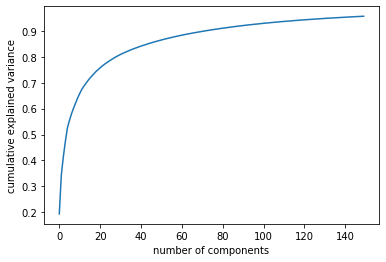

In [16]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

This curve quantifies how much of the total, 1850 dimensional variance is contained within the first N components. For example, we see that with the digits the first 10 components contain approximately 65% of the variance, the first 20 components contain approximately 80% of the variance while you need around all 150 components to describe over 90% of the variance. That would lead us to believe that using these 150 components, we would recover most of the essential characteristics of the data

## Plotting eigenfaces

Sklearn's PCA attributes explanation:

**components_**: array, shape (n_components, n_features)
- Principal axes in feature space, representing the directions of maximum variance in the data. **The components are sorted by explained_variance_.**


**explained_variance_**: array, shape (n_components,)
- The amount of variance explained by each of the selected components.
- Equal to n_components largest eigenvalues of the covariance matrix of X.

In [13]:
pca.components_.shape

(150, 1850)

So this is 150 PCs sorted from highest explained variance (which is pca.components_[0]) to lowest (pca.components_[149])

Since each principal axis is represented in a 1850-dimension feature space, which is 50x37, it would be fun to visualize each principal axis as a image of height 50 and width 37

In [6]:
eigenfaces.shape

(150, 50, 37)

In [11]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

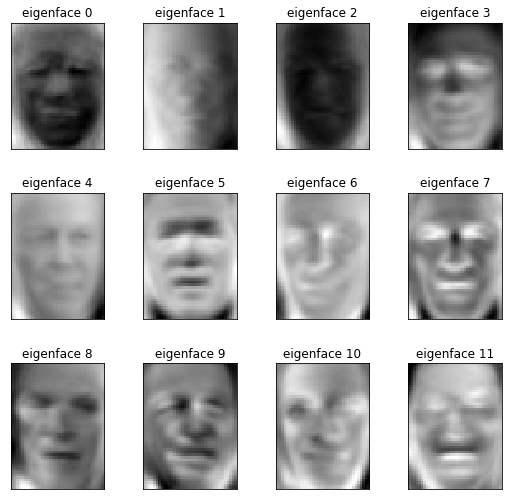

In [12]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

the first few eigenfaces (from the top left) seem to be associated with the angle of lighting on the face, and later principal vectors seem to be picking out certain features, such as eyes, noses, and lips

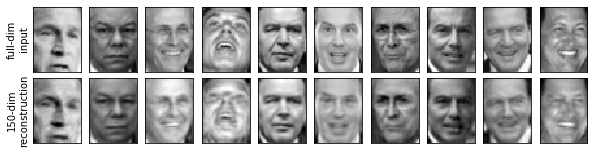

In [20]:
# try to reconstruct the original data using inverse_transform

reconstructed = pca.inverse_transform(X_train_pca)

fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(X_train[i].reshape(h, w), cmap='binary_r')
    ax[1, i].imshow(reconstructed[i].reshape(h, w), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');